# Diffim Sprint Cutouts Attempt

Converting the DM-27813 notebook to Postgres + Gen3

In [5]:
import functools
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib import cm
import os
import pandas as pd
import sqlite3
import json
import astropy.visualization as aviz

import lsst.daf.butler as dafButler
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

import lsst.geom
from lsst.ip.diffim import GetCoaddAsTemplateTask

In [4]:
import sys
sys.path.append('/project/mrawls/ap_pipe-notebooks/')
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [8]:
repo = '/datasets/hsc/gen3repo/rc2w50_ssw02'
butler = dafButler.Butler(repo)
collections = 'u/mrawls/ApPipe_smallrun_DM28555_bestSeeing'

In [27]:
# The URL where the output files can be accessed by zooniverse.
#url_root = "https://lsst.ncsa.illinois.edu/~parejkoj/zooniverse/"
url_root = "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/"

# The path to write the PNG and manifest files to.
output_path = "/scratch/ebellm/zooniverse/"

First we want to get a random subset of DIASources from the APDB.

In [8]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
#ds_sample = pd.read_sql_query('select * from DiaSource LIMIT 100;', connection)
#ds_sample = pd.read_sql_query('select * from DiaSource ORDER BY RANDOM() LIMIT 200;', connection)

CPU times: user 8.02 s, sys: 11.1 s, total: 19.1 s
Wall time: 2min 56s


In [9]:
schema = 'mrawls_smallrun2_bestSeeing' 
objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo, dbType='postgres', dbName='lsstdevapdb1', schema=schema)

In [10]:
srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable)

## Get calexp, template, and difference cutouts for each source

In [20]:
# @functools.lru_cache()
# NOTE: dataId is a dict, which is not hashable thus not cacheable
def get_images(dataId, collections):
    exposure = butler.get('calexp', dataId=dataId, collections=collections)
    difference = butler.get('deepDiff_differenceExp', dataId=dataId, collections=collections)
    template = butler.get('deepDiff_warpedExp', dataId=dataId, collections=collections)
    return exposure, difference, template

def get_cutouts(dataId, collections, center, size=lsst.geom.Extent2I(30, 30)):
    """Return a cutout for this dataId at the given source location."""
    # TODO: We can make this a lot faster by loading the images for every "ccd/visit" combo,
    # TODO: and then making the cutouts at each source that lies on that ccd.
    exposure, difference, template = get_images(dataId, collections)
    return exposure.getCutout(center, size), difference.getCutout(center, size), template.getCutout(center, size)

In [32]:
# an example dataId and center for playing with making a single image.
i=18
dataId={'detector': int(srcTable['ccd'][i]), 'visit': int(srcTable['visit'][i]), 'instrument': 'HSC'}
center=lsst.geom.SpherePoint(srcTable['ra'][i], srcTable['decl'][i], lsst.geom.degrees)
exposure, difference, template = get_cutouts(dataId, collections, center)

## Plot the images

In [33]:
def plot_cutout(science, difference, template, output=None):
    """Plot the cutouts for a source in one image.
    """
    Qst=15 #Q for Science and Template
    sst=4 #Stretch for Science and Template
    Qd=5 #Q for Difference
    sd=50 #Stretch for Difference
    asinst=0.01
    asind=0.7

    def do_one(ax, data, name):
        interval = aviz.ZScaleInterval()

        if name == 'Difference':
            norm = aviz.ImageNormalize(data,  stretch=aviz.LinearStretch())
        else:
            norm = aviz.ImageNormalize(data, interval=interval, stretch=aviz.AsinhStretch(a=0.01))
        ax.imshow(data, cmap=cm.bone, interpolation="none")
        ax.axis('off')
        ax.set_title(name)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_one(ax1, template.image.array, "Template")
    do_one(ax2, science.image.array, "Science")
    do_one(ax3, difference.image.array, "Difference")
    plt.tight_layout()

    if output is not None:
        plt.savefig(output, bbox_inches="tight")
        plt.close()

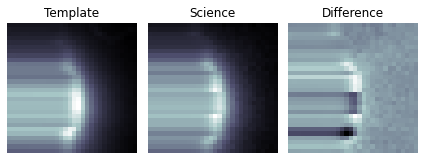

In [34]:
plot_cutout(exposure, difference, template)

## Compute metrics on cutouts

In [66]:
difference.getHeight()

30

In [76]:
def compute_pixel_difference_ratio_metric(exposure, center, nPixSide=6):

    cutoutDims = (exposure.getWidth(), exposure.getHeight())
    assert((nPixSide <= cutoutDims[0]) & (nPixSide <= cutoutDims[1]))
    
    size=lsst.geom.Extent2I(nPixSide,nPixSide)

    cutout = exposure.getCutout(center, size)
    
    arr = cutout.image.array
    # blow up if it's not square for now
    assert(arr.shape[0] == arr.shape[1])
    wPosPix = arr >=0
    nPosPix = np.sum(wPosPix)
    nNegPix = np.sum(~wPosPix)
    
    return (nPosPix - nNegPix)/(nPosPix + nNegPix)

In [51]:
compute_pixel_difference_ratio_metric(difference)


0.5222222222222223

In [83]:
# TODO: as currently written, this is going to be *very* slow because it re-loads the images for every source.
metrics = {}
for index,source in srcTable[:100].iterrows():
    center = lsst.geom.SpherePoint(source['ra'], source['decl'], lsst.geom.degrees)
    dataId = {'detector': int(srcTable['ccd'][i]), 'visit': int(srcTable['visit'][i]), 'instrument': 'HSC'}
    #exposure, difference, template = get_cutouts(dataId, collections, center)
    size=lsst.geom.Extent2I(30, 30)
    try:
        difference = butler.get('deepDiff_differenceExp', dataId=dataId, collections=collections).getCutout(center, size)
        metric_6x6 = compute_pixel_difference_ratio_metric(difference, center, nPixSide=6)
        metric_30x30 = compute_pixel_difference_ratio_metric(difference, center, nPixSide=30)
        metrics[source['diaSourceId']] = {'pixel_difference_ratio_6x6': metric_6x6,
                         'pixel_difference_ratio_30x30': metric_30x30}
    except Exception as e:
        print(e)
        continue

In [84]:
df_metrics = pd.DataFrame.from_dict(metrics,orient='index')

In [85]:
df_metrics

,pixel_difference_ratio_6x6,pixel_difference_ratio_30x30
10057340233449697,-0.333333,-0.255556
10057340233449698,0.555556,0.186667
10057340233449699,0.111111,-0.057778
10057340233449700,-1.000000,-0.068889
10057340233449701,0.388889,-0.028889
...,...,...
10057340233449791,-1.000000,-0.100000
10057340233449792,-0.444444,-0.044444
10057340233449793,-0.777778,-0.453333
10057340233449794,0.500000,0.053333


Text(0, 0.5, 'pixel_difference_ratio_30x30')

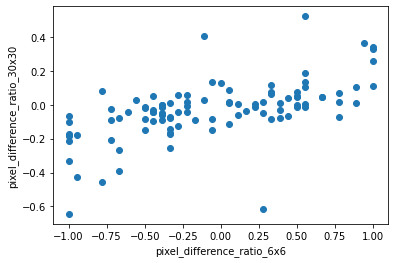

In [88]:
plt.scatter(df_metrics.pixel_difference_ratio_6x6, df_metrics.pixel_difference_ratio_30x30)
plt.xlabel('pixel_difference_ratio_6x6')
plt.ylabel('pixel_difference_ratio_30x30')


In [91]:
df_metrics[df_metrics.pixel_difference_ratio_30x30 < -0.5]

,pixel_difference_ratio_6x6,pixel_difference_ratio_30x30
10057340233449809,-1.000000,-0.644444
10057340233449766,0.277778,-0.615556


## Generate manifest information for upload to Zooniverse

In [15]:
def make_manifest(data, url_root):
    output = pd.DataFrame([])
    output['external_id'] = data['diaSourceId']
    output['location:1'] = ds_sample.apply(lambda x: f"{url_root}{x['diaSourceId']}.png", axis=1)
    output['metadata:diaSourceId'] = data['diaSourceId']
    return output

## Make plots for every source

In [89]:
# TODO: as currently written, this is going to be *very* slow because it re-loads the images for every source.
for index,source in srcTable[:100].iterrows():
    center = lsst.geom.SpherePoint(source['ra'], source['decl'], lsst.geom.degrees)
    dataId = {'detector': int(srcTable['ccd'][i]), 'visit': int(srcTable['visit'][i]), 'instrument': 'HSC'}
    exposure, difference, template = get_cutouts(dataId, collections, center)
    filename = f"{source['diaSourceId']}.png"
    plot_cutout(exposure, difference, template, output=f"{output_path}{filename}")

## Submit data to Panoptes

In [38]:
import panoptes_client
import sys,os,os.path,logging,json
# Add panoptes API client debugging to Stderr
os.environ['PANOPTES_DEBUG'] = 'true'
os.environ['PANOPTES_DEBUG']

'true'

In [39]:
# Get access to the API client logs
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

In [17]:
manifest = make_manifest(ds_sample, url_root)
manifest.to_csv(os.path.join(output_path, "manifest.csv"), index=False)

In [18]:
client = panoptes_client.Panoptes.connect(login="interactive")

Enter your Zooniverse credentials...


Username:  ebellm
 ······························


In [45]:
project = panoptes_client.Project.find(slug='ebellm/alert-production-zoo')

panoptes_client - DEBUG - params={'slug': 'ebellm/alert-production-zoo'}
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/projects?slug=ebellm%2Falert-production-zoo HTTP/1.1" 200 None


In [46]:
project.id

'11152'

In [47]:
print([(ss.id, ss.display_name) for ss in project.links.subject_sets])

redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/subject_sets/80863 HTTP/1.1" 200 None
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/subject_sets/81026 HTTP/1.1" 200 None
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/subject_sets/92664 HTTP/1.1" 200 None


[('80863', 'HiTS'), ('81026', 'HSC-COSMOS'), ('92664', 'saha')]


In [48]:
# make a new subject set
subject_set = panoptes_client.SubjectSet()

subject_set.links.project = project
subject_set.display_name = 'saha2'

subject_set.save()
project.reload()

panoptes_client - DEBUG - json={'subject_sets': {'display_name': 'saha2', 'links': {'project': '11152'}}}
redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - Resetting dropped connection: www.zooniverse.org
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /api/subject_sets HTTP/1.1" 201 None
panoptes_client - DEBUG - params={'slug': None}
redo - DEBUG - attempt 1/5
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/projects/11152 HTTP/1.1" 200 None


In [23]:
#subject_set = panoptes_client.SubjectSet.find(90418)


In [31]:
# ensure we're using the the secure HTTPS protocol (not HTTP)
client.endpoint

'https://www.zooniverse.org'

In [49]:
payload_dict = {"subject_set_imports": {"source_url": f"{url_root}manifest.csv", "links": {"subject_set": subject_set.id}}}

json.dumps(payload_dict)

'{"subject_set_imports": {"source_url": "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv", "links": {"subject_set": "92666"}}}'

In [50]:
# request the import via the API client (custom path as this isn't an exposed resource in the client)
# this should be added to the Zooniverse python client / cli tools to improve the user experience
# https://github.com/zooniverse/panoptes-python-client/issues/255
json_response, etag = client.post(path='/subject_set_imports', json=payload_dict)

panoptes_client - DEBUG - json={'subject_set_imports': {'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv', 'links': {'subject_set': '92666'}}}
redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "POST /api/subject_set_imports HTTP/1.1" 201 None


In [51]:
json_response

{'subject_set_imports': [{'id': '6',
   'href': '/subject_set_imports/6',
   'created_at': '2021-02-25T22:46:42.594Z',
   'updated_at': '2021-02-25T22:46:42.594Z',
   'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv',
   'links': {'subject_set': '92666', 'user': '1649740'}}],
 'links': {'subject_set_imports.subject_set': {'href': '/subject_sets/{subject_set_imports.subject_set}',
   'type': 'subject_sets'},
  'subject_set_imports.user': {'href': '/users/{subject_set_imports.user}',
   'type': 'users'}},
 'meta': {'subject_set_imports': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_set_imports',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_set_imports'}}}

In [52]:
subject_set_imports_path = '/subject_set_imports/{}'.format(json_response['subject_set_imports'][0]['id'])
json_response, etag = client.get(path=subject_set_imports_path)

redo - DEBUG - attempt 1/1
urllib3.connectionpool - DEBUG - https://www.zooniverse.org:443 "GET /api/subject_set_imports/6 HTTP/1.1" 200 None


In [53]:
json_response

{'subject_set_imports': [{'id': '6',
   'href': '/subject_set_imports/6',
   'created_at': '2021-02-25T22:46:42.594Z',
   'updated_at': '2021-02-25T22:46:42.594Z',
   'source_url': 'https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/manifest.csv',
   'links': {'subject_set': '92666', 'user': '1649740'}}],
 'links': {'subject_set_imports.subject_set': {'href': '/subject_sets/{subject_set_imports.subject_set}',
   'type': 'subject_sets'},
  'subject_set_imports.user': {'href': '/users/{subject_set_imports.user}',
   'type': 'users'}},
 'meta': {'subject_set_imports': {'page': 1,
   'page_size': 20,
   'count': 1,
   'include': [],
   'page_count': 1,
   'previous_page': None,
   'next_page': None,
   'first_href': '/subject_set_imports?id=6',
   'previous_href': None,
   'next_href': None,
   'last_href': '/subject_set_imports?id=6'}}}